In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [31]:
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import xgboost

#### Yearly changes

In [103]:
power5 = ["Boston College", "Baylor", "Illinois", "Arizona", "Alabama", "Clemson", "Iowa State", "Indiana", "Arizona State", "Arkansas", "Duke", "Kansas", "Iowa", "California", "Auburn", "Florida State", "Kansas State", "Maryland", "UCLA", "Florida", "Georgia Tech", "Oklahoma", "Michigan", "Colorado", "Georgia", "Louisville", "Oklahoma State", "Michigan State", "Oregon", "Kentucky", "Miami", "TCU", "Minnesota", "Oregon State", "LSU", "North Carolina", "Texas", "Nebraska", "USC", "Mississippi", "North Carolina State", "Texas Tech", "Northwestern", "Stanford", "Mississippi State", "Pittsburgh", "West Virginia", "Ohio State", "Utah", "Missouri", "Syracuse", "Penn State", "Washington", "South Carolina", "Virginia", "Purdue", "Washington State", "Tennessee", "Virginia Tech", "Rutgers", "Texas A&M", "Wake Forest", "Wisconsin", "Vanderbilt", "Notre Dame"]
print len(power5)

65


In [104]:
def got_fired_following_season(team):
    team_totals = df[df['Team'] == team]
    for line in open("yearly_changes_by_team2003.csv", "r"):
        if line.split(",")[0] == team:
            years = line.split(",")[1:]
            for year in years:
                year = year.strip()
                df.loc[(df['Team']== team) & (df['Year']== str(int(year) - 2)), 'LeavesNextYr'] = 1
    return df



def tenure(team):
    team_df = df[df['Team'] == team]
    year_min = team_df[team_df['LeavesNextYr'] == 1]
    years = year_min['Year'].tolist()
    if len(years) > 0: #The Bob Stoops exception
        
        years.sort()
        min_year = years[0]
        year = int(min_year)
        counter = 0
        while year <= 2015:
            if int(year) - 1 in map(int, years):
                counter = 1
                df.loc[(df['Year'] == str(year)) & (df['Team'] == team), 'Tenure'] = 0
            else:
                df.loc[(df['Year'] == str(year)) & (df['Team'] == team), 'Tenure'] = counter
                counter += 1
            year += 1
        
    return df


def expectations(team, year):
    team_df = df[df['Team'] == team]
    first_year = int(year) - 6
    total_wins = 0
    total_games = 0
    for season in range(first_year, year):
        wins = team_df.loc[(team_df['Year'] == str(season)), 'Wins']
        games = team_df.loc[(team_df['Year'] == str(season)), 'Games']
        try:
            total_wins += int(wins)
            total_games += int(games)
        except TypeError:
            total_wins += 0
            total_games += 0
    try:
        expectations = float(total_wins)/total_games
    except ZeroDivisionError:
        expectations = 5
    df.loc[(df['Year'] == str(year)) & (df['Team'] == team), 'PreSeasonExpectations'] = expectations
    return df

In [105]:
import glob

columns = ["Team","Wins","Losses","Ties","Games","WinPct", "Year"]

df = pd.DataFrame(columns=columns)


for filename in glob.glob("*records.csv"):
    year = filename.split("_")[0]
    f = DataFrame.from_csv(filename, header = None, index_col=False)
    f['Year'] = year
    f.columns = columns
    dfs = [df, f]
    df = pd.concat(dfs)
df = df.reset_index()
del df['index']


df['LeavesNextYr'] = 0
df['Tenure'] = 0
df['PreSeasonExpectations'] = 0
df['IsPower5'] = 0


In [106]:
for index, row in df.iterrows():
    if row['Team'] in power5:
        df.ix[index, 'IsPower5'] = 1

In [107]:
teams = df['Team'].unique()

for team in teams:
    df = got_fired_following_season(team)
    tenure(team)
    

In [108]:
seasons = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
for season in seasons:
    for team in teams:
        expectations(team, season)

# Clean Data, Separate Training and Test Sets

In [124]:
df[['Year','Tenure']] = df[['Year','Tenure']].apply(pd.to_numeric)
df['ExpVsReality'] = df['WinPct'] - df['PreSeasonExpectations']
training_set = df[df['Tenure'] > 0]
test_set = training_set[training_set['Year'] == 2015]
training_set = training_set[training_set['Year'] < 2015]
training_set = training_set.reset_index(drop = True)
training_set

,Team,Wins,Losses,Ties,Games,WinPct,Year,LeavesNextYr,Tenure,PreSeasonExpectations,IsPower5,ExpVsReality
0,Utah,10.0,2.0,0.0,12.0,0.83333,2003,1,1,0.573529,1,0.259801
1,Bowling Green,11.0,3.0,0.0,14.0,0.78571,2003,0,1,0.477612,0,0.308098
2,Louisville,9.0,4.0,0.0,13.0,0.69231,2003,0,1,0.575342,1,0.116968
3,Oregon State,8.0,5.0,0.0,13.0,0.61538,2003,0,1,0.557143,1,0.058237
4,Tulsa,8.0,5.0,0.0,13.0,0.61538,2003,0,1,0.220588,0,0.394792
5,Houston,7.0,6.0,0.0,13.0,0.53846,2003,0,1,0.313433,0,0.225027
6,Washington,6.0,6.0,0.0,12.0,0.50000,2003,1,1,0.643836,1,-0.143836
7,UCLA,6.0,7.0,0.0,13.0,0.46154,2003,0,1,0.633803,1,-0.172263
8,Texas A&M,4.0,8.0,0.0,12.0,0.33333,2003,0,1,0.653333,1,-0.320003
9,Wyoming,4.0,8.0,0.0,12.0,0.33333,2003,0,1,0.405797,0,-0.072467


# Prepare Balanced Training Set

First, select all minority class data. Then, randomly select majority class samples (without replacement) and compile. Then, shuffle the data set to randomly order majority and minority classes.

In [125]:
canned = training_set[training_set['LeavesNextYr'] == 1]
kept = training_set[training_set['LeavesNextYr'] == 0]
training_kept = kept.sample(n=canned.shape[0])
training_kept = training_kept.reset_index(drop = True)


In [126]:
training_data = pd.concat([training_kept, canned])
training_data = training_data.reset_index(drop = True)
training_data = training_data.reindex(np.random.permutation(training_data.index))
training_data = training_data.reset_index(drop=True)
training_data

,Team,Wins,Losses,Ties,Games,WinPct,Year,LeavesNextYr,Tenure,PreSeasonExpectations,IsPower5,ExpVsReality
0,East Carolina,10.0,3.0,0.0,13.0,0.76923,2013,0,4,0.569620,0,0.199610
1,Texas A&M,9.0,4.0,0.0,13.0,0.69231,2010,1,3,0.513514,1,0.178796
2,Kansas State,6.0,6.0,0.0,12.0,0.50000,2009,0,1,0.500000,1,0.000000
3,Louisville,11.0,2.0,0.0,13.0,0.84615,2012,1,3,0.546667,1,0.299483
4,Utah,13.0,0.0,0.0,13.0,1.00000,2008,0,4,0.698630,1,0.301370
5,Baylor,11.0,2.0,0.0,13.0,0.84615,2014,1,7,0.578947,1,0.267203
6,Akron,1.0,11.0,0.0,12.0,0.08333,2010,1,1,0.416667,0,-0.333337
7,Ball State,9.0,4.0,0.0,13.0,0.69231,2012,0,2,0.480000,0,0.212310
8,Michigan,5.0,7.0,0.0,12.0,0.41667,2009,1,2,0.653333,1,-0.236663
9,Maryland,7.0,6.0,0.0,13.0,0.53846,2014,1,4,0.426667,1,0.111793


In [127]:
features_training = training_data[["Tenure", "ExpVsReality", 'IsPower5']]
outcome_training = training_data["LeavesNextYr"]


## Scale Data

In [128]:
scaler = StandardScaler()
features_training = scaler.fit_transform(features_training)
print features_training.shape, outcome_training.shape

(306, 3) (306,)


# Evaluate Different Models
* Logistic Regression
* Random Forest
* Support Vector Machine
* K-Nearest Neighbors
* Gradient Boosting

In [129]:
logreg2 = LogisticRegression()
scores=cross_val_score(logreg2, features_training, outcome_training, cv=10, scoring='accuracy')
print scores
print scores.mean()

[ 0.625       0.625       0.71875     0.66666667  0.6         0.6         0.5
  0.36666667  0.73333333  0.53333333]
0.596875


In [130]:
rf_model2 = RandomForestClassifier()
scores=cross_val_score(rf_model2, features_training, outcome_training, cv=10, scoring='accuracy')
print scores
print scores.mean()

[ 0.625       0.5625      0.46875     0.5         0.56666667  0.5         0.5
  0.3         0.56666667  0.53333333]
0.512291666667


In [131]:
svm_model2=svm.SVC(probability = True)
scores=cross_val_score(svm_model2, features_training, outcome_training, cv=10, scoring='accuracy')
print scores
print scores.mean()

[ 0.53125     0.65625     0.75        0.7         0.66666667  0.5
  0.63333333  0.5         0.56666667  0.73333333]
0.62375


In [132]:
xgb = xgboost.XGBClassifier()
scores=cross_val_score(xgb, features_training, outcome_training, cv=10, scoring='accuracy')
print scores
print scores.mean()

[ 0.5         0.6875      0.59375     0.56666667  0.5         0.63333333
  0.63333333  0.43333333  0.56666667  0.5       ]
0.561458333333


In [133]:
k_range=range(1,51)
k_scores1=[]
for k in k_range:
    knn1 = KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn1, features_training, outcome_training, cv=10, scoring='accuracy')
    k_scores1.append(scores.mean())
avg_kscore = sum(k_scores1)/len(k_scores1)
print avg_kscore

0.586845833333


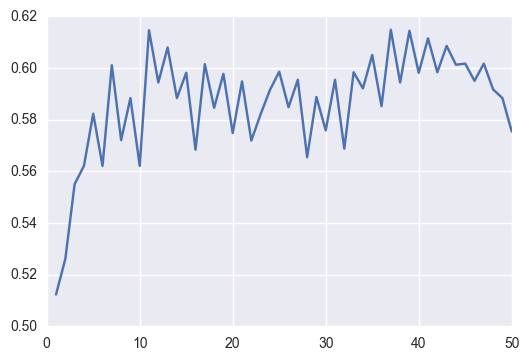

In [134]:
plt.plot(k_range, k_scores1)
plt.show()

In [135]:
svm_model2.fit(features_training, outcome_training)
rf_model2.fit(features_training, outcome_training)
knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(features_training, outcome_training)
logreg2.fit(features_training, outcome_training)
xgb.fit(features_training, outcome_training)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

# Make Predictions

In [136]:
test_data = test_set[["Tenure", "ExpVsReality", 'IsPower5']]
features_test = scaler.transform(test_data)
bu = test_set.reset_index(drop=True)


In [137]:
max_prob = 0
spot = 0
for n in range(0,len(features_test)):
    stats = features_test[n].tolist()
    prob_fired = svm_model2.predict_proba([stats])[0][1]
    bu.ix[n, 'SVM'] = prob_fired
    prob_fired = logreg2.predict_proba([stats])[0][1]
    bu.ix[n, 'LogReg'] = prob_fired
    prob_fired = rf_model2.predict_proba([stats])[0][1]
    bu.ix[n, 'RF'] = prob_fired
    prob_fired = knn10.predict_proba([stats])[0][1]
    bu.ix[n, 'KNN10'] = prob_fired
    prob_fired = xgb.predict_proba([stats])[0][1]
    bu.ix[n, 'XGBoost'] = prob_fired

In [145]:
model = 'SVM'
sorted_df = bu.sort([model], ascending = False)
sorted_df = sorted_df[['Team', 'Wins', 'Losses', 'Tenure', 'ExpVsReality', 'IsPower5', model]]
sorted_df = sorted_df.reset_index(drop = True)
sorted_df

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Team,Wins,Losses,Tenure,ExpVsReality,IsPower5,SVM
0,Arizona State,6.0,7.0,4,-0.109889,1,0.654780
1,Arizona,7.0,6.0,4,-0.038463,1,0.649810
2,Louisiana-Lafayette,4.0,8.0,5,-0.258775,0,0.649397
3,Texas A&M,8.0,5.0,4,-0.025646,1,0.648170
4,Miami-Ohio,3.0,9.0,5,-0.033784,0,0.645717
5,Stanford,12.0,2.0,5,0.082140,1,0.645477
6,West Virginia,8.0,5.0,5,0.017977,1,0.644998
7,Fresno State,3.0,9.0,4,-0.332278,0,0.644110
8,UCLA,8.0,5.0,4,0.033102,1,0.640880
9,Indiana,6.0,7.0,5,0.142096,1,0.635706


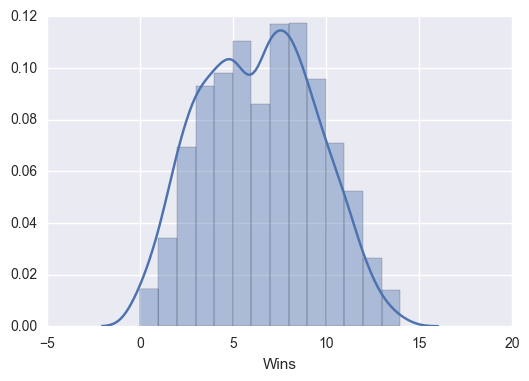

In [141]:
sns.distplot(df['Wins'], bins = 14)

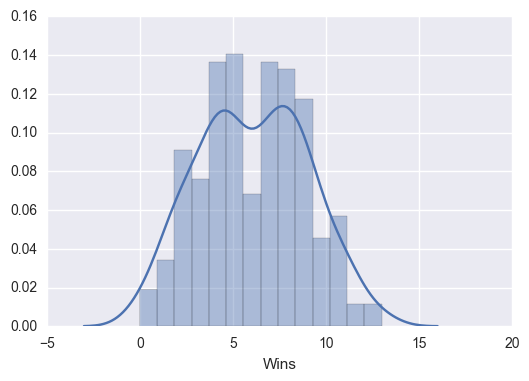

In [142]:
gone = df[df['LeavesNextYr'] == 1]
sns.distplot(gone['Wins'], bins = 14)